In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import warnings
import seaborn as sns
from pandas.errors import SettingWithCopyWarning


FIGSIZE_1 = (6,6)
FIGSIZE_2 = (7,7)

warnings.filterwarnings('ignore', category=UserWarning) 
warnings.filterwarnings('ignore', category=SettingWithCopyWarning)


# Setting the basepath, needs to be adjusted depending on the folder structure
basepath = Path(r"path")
picture_savepath = os.path.join(basepath, "pictures")
if not os.getcwd() == basepath:
    os.chdir(basepath)
    

In [2]:
# Importing the data
df = pd.read_csv("abcnews-date-text.csv")
# Limit the data to 5000 rows due to computational limitations
df = df.sample(n = 5000, random_state= 123)
df.head()

,publish_date,headline_text
849028,20140127,qld's first cyclone predicted to form in coral...
725884,20120919,wa government backs down over parking fees
709535,20120720,interview bill leak
195646,20051020,spanish judge issues warrants for us soldiers
560834,20100902,rising swan ready for all comers


In [ ]:
# Check for missing values
print(df.isna().value_counts())
print(df.isnull().value_counts())

publish_date  headline_text
False         False            5000
dtype: int64
publish_date  headline_text
False         False            5000
dtype: int64


In [4]:
# Drop unecessary column as it is not relevant for this task
df_text = df.drop(columns="publish_date")
df_text.head()

,headline_text
849028,qld's first cyclone predicted to form in coral...
725884,wa government backs down over parking fees
709535,interview bill leak
195646,spanish judge issues warrants for us soldiers
560834,rising swan ready for all comers


In [5]:
# Getting the first 10 entries of the duplicates
df_text[df_text['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(10)

,headline_text
646425,abc business news and market analysis
755694,abc business news and market analysis
498889,abc business news and market analysis
741479,abc entertainment
685859,abc entertainment
653815,abc sport
754015,abc sport
774505,abc sport
726264,abc sport
786355,abc sport


In [6]:
# Getting number of duplicated texts in total
df_text[df_text['headline_text'].duplicated(keep=False)].sort_values('headline_text').value_counts()

headline_text                        
abc sport                                5
national rural news                      4
abc business news and market analysis    3
abc weather                              3
abc entertainment                        2
country wide                             2
interview brian smith                    2
national rural news for wednesday        2
wednesday finance with alan kohler       2
dtype: int64

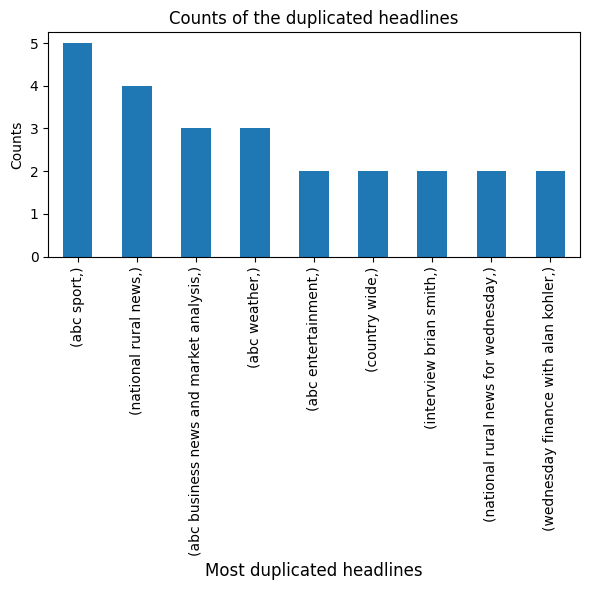

In [7]:
plt.figure(figsize=FIGSIZE_1)
df_text[df_text['headline_text'].duplicated(keep=False)].\
    sort_values('headline_text').value_counts().plot(kind="bar",
                                                    ylabel="Counts", title= "Counts of the duplicated headlines")

plt.xlabel("Most duplicated headlines", fontdict={"fontsize": 12})
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Headline duplicates.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [8]:
# Cleaning the dataframe from duplicates
df_text_clean = df_text.drop_duplicates(subset='headline_text')
df_text_clean.head()

# https://www.kaggle.com/code/thebrownviking20/k-means-clustering-of-1-million-headlines

,headline_text
849028,qld's first cyclone predicted to form in coral...
725884,wa government backs down over parking fees
709535,interview bill leak
195646,spanish judge issues warrants for us soldiers
560834,rising swan ready for all comers


In [9]:
# Finding out if any of these unwanted characters !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ are int the dataframe
import string
unwanted_chars = string.punctuation + string.digits

df_text_clean["headline_text"].str.strip(unwanted_chars).astype(bool).any()

True

In [10]:
# Replacing the unwanted characters by whitespace
df_text_clean["headline_text"] = df_text_clean["headline_text"].replace(unwanted_chars, '')


In [11]:
# Creating function for lowering all the texts to lower format and applying it on the data
def toLower(text: str) -> str:
    return text.lower()

df_text_clean["headline_text"] = df_text_clean["headline_text"].apply(toLower)

In [12]:
# Converting the dataframe into a list with all the text data for the countvectorizer
import numpy as np

raw_text_list = np.concatenate( df_text_clean.values).ravel().tolist()

In [5]:
# Complete preprocessing in one function
import string
import numpy as np


def toLower(text: str) -> str:
    return text.lower()

def preprocessing(data: pd.DataFrame) -> list | pd.DataFrame:
    """Preprocessing function for the abcnews data"""
    # Dropping the publish date as it has no relevance for clustering
    df_text = data.drop(columns="publish_date")
    
    print("First 10 duplicates from the dataset:")
    print(df_text[df_text['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(10))
    
    print("Number of duplicates in total:")
    print(df_text[df_text['headline_text'].duplicated(keep=False)].sort_values('headline_text').value_counts())
    # Dropping duplicates to clean up the data
    df_text_clean = df_text.drop_duplicates(subset='headline_text')
    # Defining unwanted characters
    unwanted_chars = string.punctuation + string.digits
    # Checking if unwanted characters exist and removing them
    df_text_clean["headline_text"].str.strip(unwanted_chars).astype(bool).any()
    df_text_clean["headline_text"] = df_text_clean["headline_text"].replace(unwanted_chars, '')
    # Lower all the text for equalization
    df_text_clean["headline_text"] = df_text_clean["headline_text"].apply(toLower)
    # Creating also a list of the text values for the vectorizers
    raw_text_list = np.concatenate( df_text_clean.values).ravel().tolist()
    return raw_text_list, df_text_clean


raw_text_list, df_text_clean = preprocessing(df)

First 10 duplicates from the dataset:
                                headline_text
646425  abc business news and market analysis
755694  abc business news and market analysis
498889  abc business news and market analysis
741479                      abc entertainment
685859                      abc entertainment
653815                              abc sport
754015                              abc sport
774505                              abc sport
726264                              abc sport
786355                              abc sport
Number of duplicates in total:
headline_text                        
abc sport                                5
national rural news                      4
abc business news and market analysis    3
abc weather                              3
abc entertainment                        2
country wide                             2
interview brian smith                    2
national rural news for wednesday        2
wednesday finance with alan kohler       2


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

stop_words = list(text.ENGLISH_STOP_WORDS)

def stemming(text: str) -> str:
    stemmer = SnowballStemmer("english")
    tokenizer = RegexpTokenizer(r"[a-zA-Z\']+")
    return [stemmer.stem(word) for word in tokenizer.tokenize(text)]

vectorizer = TfidfVectorizer(stop_words= stop_words, tokenizer= stemming)

vect_text = vectorizer.fit_transform(raw_text_list)

word_features = vectorizer.get_feature_names_out()

print(len(word_features))
print(word_features[:50])



6528
['aaco' 'aami' 'ab' 'abandon' 'abattoir' 'abba' 'abbot' 'abbott' 'abc'
 'abcc' 'abdirahman' 'abduct' 'abdul' 'abe' 'abetz' 'abil' 'abl'
 'aborigin' 'abort' 'abov' 'absent' 'abu' 'abus' 'academ' 'accc' 'accept'
 'access' 'acci' 'accid' 'accident' 'accommod' 'account' 'accus' 'accuss'
 'ace' 'acknowledg' 'acl' 'acland' 'acoss' 'acquit' 'act' 'actew' 'action'
 'activ' 'activist' 'actress' 'actu' 'ad' 'ada' 'adam']


In [15]:
vect_text.getrow(0).data

array([0.34337013, 0.35964214, 0.45301708, 0.40740637, 0.40021827,
       0.36290561, 0.29945769])

In [7]:
# Dimensionality reduction for visualization
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore', category=FutureWarning) 

pca = PCA(n_components=2 , random_state= 123)
pca_vecs = pca.fit_transform(vect_text.toarray())

x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]


df_text_clean['x0'] = x0
df_text_clean['x1'] = x1

"""
Commented out since it only remains if a more specific look in detail is necessary

import seaborn as sns

plt.figure(figsize=FIGSIZE_1)
plt.title("PCA Dimensionality reduction without clustering")
plt.xlabel("X0")
plt.ylabel("X1")
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1")
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "PCA reduction.png"), bbox_inches = "tight", dpi = 400)
plt.show()

"""

'\nCommented out since it only remains if a more specific look in detail is necessary\n\nimport seaborn as sns\n\nplt.figure(figsize=FIGSIZE_1)\nplt.title("PCA Dimensionality reduction without clustering")\nplt.xlabel("X0")\nplt.ylabel("X1")\nsns.scatterplot(data= df_text_clean, x = "x0", y = "x1")\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "PCA reduction.png"), bbox_inches = "tight", dpi = 400)\nplt.show()\n\n'

In [8]:
# Tryout with another dimensionality reduction
# Try it with deep autoencoder

from sklearn.manifold import TSNE

warnings.filterwarnings('ignore', category=FutureWarning) 

tsne = TSNE(n_components= 2, perplexity= 100 , random_state= 123)
tsne_vec = tsne.fit_transform(vect_text.toarray())

x0 = tsne_vec[:, 0]
x1 = tsne_vec[:, 1]

df_text_clean2 = df_text_clean['headline_text'].copy()


df_text_clean2['x0'] = x0
df_text_clean2['x1'] = x1

"""
Commented out since it only remains if a more specific look in detail is necessary

import seaborn as sns

plt.figure(figsize=FIGSIZE_1)
plt.title("TSNE Dimensionality reduction without clustering", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean2, x = "x0", y = "x1")
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "TSNE reduction.png"), bbox_inches = "tight", dpi = 400)
plt.show()
"""     

'\nCommented out since it only remains if a more specific look in detail is necessary\n\nimport seaborn as sns\n\nplt.figure(figsize=FIGSIZE_1)\nplt.title("TSNE Dimensionality reduction without clustering", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean2, x = "x0", y = "x1")\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "TSNE reduction.png"), bbox_inches = "tight", dpi = 400)\nplt.show()\n'

In [9]:
# Try it with deep autoencoder

from sklearn.decomposition import FastICA

warnings.filterwarnings('ignore', category=FutureWarning) 

ica = FastICA(n_components= 2, random_state= 123)
ica_vec = ica.fit_transform(vect_text.toarray())

x0 = ica_vec[:, 0]
x1 = ica_vec[:, 1]

df_text_clean3 = df_text_clean['headline_text'].copy()


df_text_clean3['x0'] = x0
df_text_clean3['x1'] = x1


"""
Commented out since it only remains if a more specific look in detail is necessary


import seaborn as sns

plt.figure(figsize=FIGSIZE_1)
plt.title("ICA Dimensionality reduction without clustering", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean3, x = "x0", y = "x1")
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "ICA reduction.png"), bbox_inches = "tight", dpi = 400)
plt.show()

"""

'\nCommented out since it only remains if a more specific look in detail is necessary\n\n\nimport seaborn as sns\n\nplt.figure(figsize=FIGSIZE_1)\nplt.title("ICA Dimensionality reduction without clustering", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean3, x = "x0", y = "x1")\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "ICA reduction.png"), bbox_inches = "tight", dpi = 400)\nplt.show()\n\n'

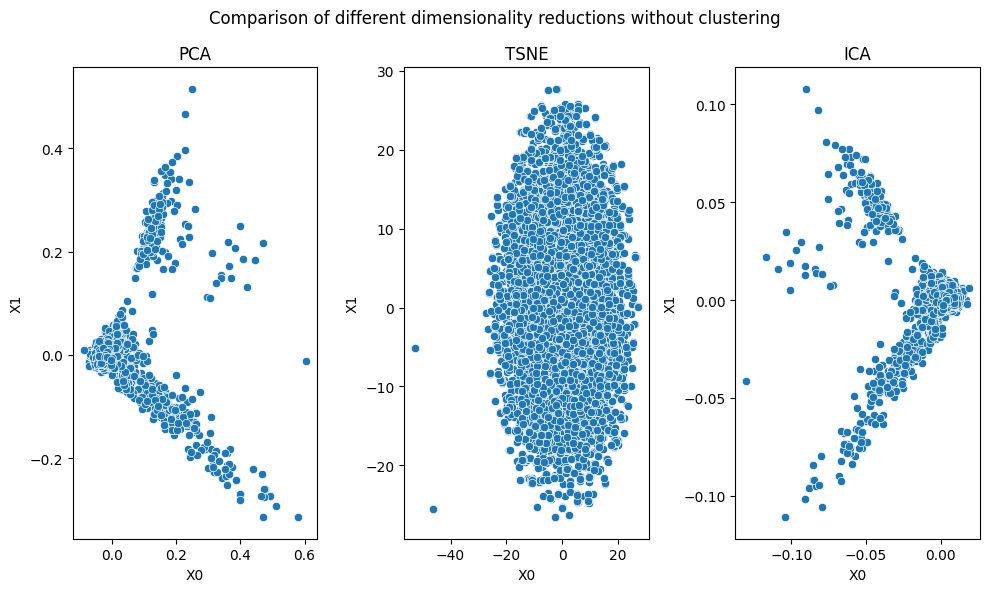

In [19]:
fig, axs = plt.subplots(1,3, figsize= (10,6))
plt.suptitle("Comparison of different dimensionality reductions without clustering")

axs[0].set_title("PCA")
axs[0].set_xlabel("X0")
axs[0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1", ax= axs[0])

axs[1].set_title("TSNE")
axs[1].set_xlabel("X0")
axs[1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean2, x = "x0", y = "x1", ax=axs[1])

axs[2].set_title("ICA")
axs[2].set_xlabel("X0")
axs[2].set_ylabel("X1")
sns.scatterplot(data= df_text_clean3, x = "x0", y = "x1", ax= axs[2])

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Reductions.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [20]:
# Basic K-Means
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore', category=FutureWarning) 

kmean = KMeans(random_state= 123)
kmean.fit(vect_text)

clusters = kmean.labels_

df_text_clean['cluster_kmeans_basic'] = clusters

"""
Commented out since it only remains if a more specific look in detail is necessary
import seaborn as sns

plt.figure(figsize=(8,8))
plt.title("TF-IDF + K-Means clustering basic 8 clusters", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
plt.legend(title = "Cluster", fontsize = 12)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "PCA TFIDF K-Means 8 cluster.png"), bbox_inches = "tight")
plt.show()
"""

'\nCommented out since it only remains if a more specific look in detail is necessary\nimport seaborn as sns\n\nplt.figure(figsize=(8,8))\nplt.title("TF-IDF + K-Means clustering basic 8 clusters", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])\nplt.legend(title = "Cluster", fontsize = 12)\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "PCA TFIDF K-Means 8 cluster.png"), bbox_inches = "tight")\nplt.show()\n'

In [21]:
# Basic K-Medoids
from sklearn_extra.cluster import KMedoids

warnings.filterwarnings('ignore', category=FutureWarning) 

# Apply K-Medoids with a predetermined number of clusters
kmedoids = KMedoids( random_state=123)
kmedoids.fit(vect_text)

# Get the cluster assignments
labels_kmedoids = kmedoids.labels_

print(len(set(labels_kmedoids)))

df_text_clean['cluster_kmedoids_basic'] = labels_kmedoids
"""
Commented out since it only remains if a more specific look in detail is necessary
import seaborn as sns

plt.figure(figsize=(8,8))
plt.title("TF-IDF + K-Medoids clustering basic 8 clusters", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmedoids_basic", hue_order=[i for i in range(0, 8)])
plt.legend(title = "Cluster", fontsize = 12)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "PCA TFIDF K-Medoids 8 cluster.png"), bbox_inches = "tight")
plt.show()
"""

8


'\nCommented out since it only remains if a more specific look in detail is necessary\nimport seaborn as sns\n\nplt.figure(figsize=(8,8))\nplt.title("TF-IDF + K-Medoids clustering basic 8 clusters", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmedoids_basic", hue_order=[i for i in range(0, 8)])\nplt.legend(title = "Cluster", fontsize = 12)\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "PCA TFIDF K-Medoids 8 cluster.png"), bbox_inches = "tight")\nplt.show()\n'

In [22]:
# Basic DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.5, min_samples=5)
db.fit(vect_text)

labels_dbscan = db.labels_

df_text_clean['cluster_dbscan_basic'] = labels_dbscan
"""
Commented out since it only remains if a more specific look in detail is necessary
import seaborn as sns

plt.figure(figsize=(8,8))
plt.title("TF-IDF + DBSCAN clustering eps= 0.5 basic clusters", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_dbscan_basic")
plt.legend(title = "Cluster", fontsize = 12)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "PCA TFIDF DBSCAN basic cluster.png"), bbox_inches = "tight")
plt.show()
"""

'\nCommented out since it only remains if a more specific look in detail is necessary\nimport seaborn as sns\n\nplt.figure(figsize=(8,8))\nplt.title("TF-IDF + DBSCAN clustering eps= 0.5 basic clusters", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_dbscan_basic")\nplt.legend(title = "Cluster", fontsize = 12)\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "PCA TFIDF DBSCAN basic cluster.png"), bbox_inches = "tight")\nplt.show()\n'

In [23]:
# Basic Agglormerative Clustering
from sklearn.cluster import AgglomerativeClustering

warnings.filterwarnings('ignore', category=FutureWarning) 

agclust = AgglomerativeClustering()
agclust.fit(vect_text.toarray())

labels_agglo = agclust.labels_

print(set(labels_agglo))

df_text_clean['cluster_agglo_basic'] = labels_agglo

"""
Commented out since it only remains if a more specific look in detail is necessary
import seaborn as sns

plt.figure(figsize=(8,8))
plt.title("TF-IDF + Agglomerative clustering basic with 2 clusters", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_agglo_basic", hue_order=[i for i in range(0, 2)])
plt.legend(title = "Cluster", fontsize = 12)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "PCA TFIDF Agglo 2 cluster.png"), bbox_inches = "tight")
plt.show()
"""

{0, 1}


'\nCommented out since it only remains if a more specific look in detail is necessary\nimport seaborn as sns\n\nplt.figure(figsize=(8,8))\nplt.title("TF-IDF + Agglomerative clustering basic with 2 clusters", fontdict={"fontsize": 16})\nplt.xlabel("X0", fontdict={"fontsize": 14})\nplt.ylabel("X1", fontdict={"fontsize": 14})\nsns.scatterplot(data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_agglo_basic", hue_order=[i for i in range(0, 2)])\nplt.legend(title = "Cluster", fontsize = 12)\nplt.tight_layout()\nplt.savefig(os.path.join(picture_savepath, "PCA TFIDF Agglo 2 cluster.png"), bbox_inches = "tight")\nplt.show()\n'

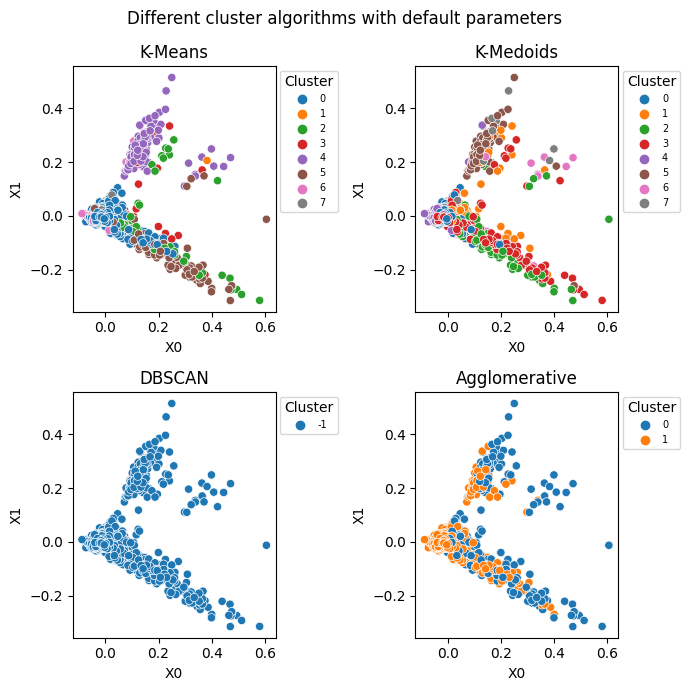

In [24]:
fig, ax = plt.subplots(2,2, figsize=FIGSIZE_2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.45,hspace=0.45)
plt.suptitle("Different cluster algorithms with default parameters")
ax[0,0].set_title("K-Means")
ax[0,0].set_xlabel("X0")
ax[0,0].set_ylabel("X1")
sns.scatterplot(ax= ax[0,0], data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
ax[0,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

ax[0,1].set_title("K-Medoids")
ax[0,1].set_xlabel("X0")
ax[0,1].set_ylabel("X1")
sns.scatterplot(ax= ax[0,1], data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmedoids_basic", hue_order=[i for i in range(0, 8)])
ax[0,1].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

ax[1,0].set_title("DBSCAN")
ax[1,0].set_xlabel("X0")
ax[1,0].set_ylabel("X1")
sns.scatterplot(ax= ax[1,0], data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_dbscan_basic")
ax[1,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

ax[1,1].set_title("Agglomerative")
ax[1,1].set_xlabel("X0")
ax[1,1].set_ylabel("X1")
sns.scatterplot(ax= ax[1,1], data= df_text_clean, x = "x0", y = "x1", palette= "tab10", hue= "cluster_agglo_basic", hue_order=[i for i in range(0, 2)])
ax[1,1].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Basic cluster comparison.png"), bbox_inches = "tight", dpi = 400)

plt.show()

In [10]:
# Using the silhouette score to determine optimal number of clusters for kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore', category=FutureWarning) 

silhouetter_scores = []
for k in range(2,20):
    kmeans = KMeans(n_clusters= k, random_state=123)
    temp_labels = kmeans.fit_predict(vect_text)
    score = silhouette_score(vect_text, temp_labels)
    silhouetter_scores.append(score)
    
optimal_clusters_kmeans = silhouetter_scores.index(max(silhouetter_scores)) + 2
print(f"Optimal number of clusters from silhouette score: {optimal_clusters_kmeans}")


# Creating a 
kmeans = KMeans(n_clusters= optimal_clusters_kmeans, random_state=123)
kmeans.fit(vect_text)
labels = kmeans.labels_

# Printing the first 15 headlines with their clusters
for i, headline in enumerate(raw_text_list[:15]):
    print(f"Headline: {headline} | Cluster: {labels[i]}") 

Optimal number of clusters from silhouette score: 17
Headline: qld's first cyclone predicted to form in coral sea this week | Cluster: 8
Headline: wa government backs down over parking fees | Cluster: 8
Headline: interview bill leak | Cluster: 12
Headline: spanish judge issues warrants for us soldiers | Cluster: 8
Headline: rising swan ready for all comers | Cluster: 8
Headline: chinese govt apologises for hostage drama | Cluster: 8
Headline: marton loses taekwondo semi finals | Cluster: 8
Headline: tigers lose kendall for season | Cluster: 8
Headline: world cup win would top the lot marsh | Cluster: 10
Headline: mick fanning's brother peter dies on eve of world title showdown | Cluster: 8
Headline: police capture drugs thought to be earmarked for schoolies | Cluster: 6
Headline: brisbane day care death lucas tran moorooka child care | Cluster: 7
Headline: probe launched into cia leak | Cluster: 8
Headline: british explorer lost in png criticised for lack of preparation | Cluster: 8
He

In [11]:
# WSS method to get the optimal number of clusters for kmeans with the elbow bend

from sklearn.cluster import KMeans

warnings.filterwarnings('ignore', category=UserWarning) 

wcss = []
for i in range(1,20):
    kmean = KMeans(n_clusters= i, random_state=123)
    kmean.fit(vect_text)
    wcss.append(kmean.inertia_)


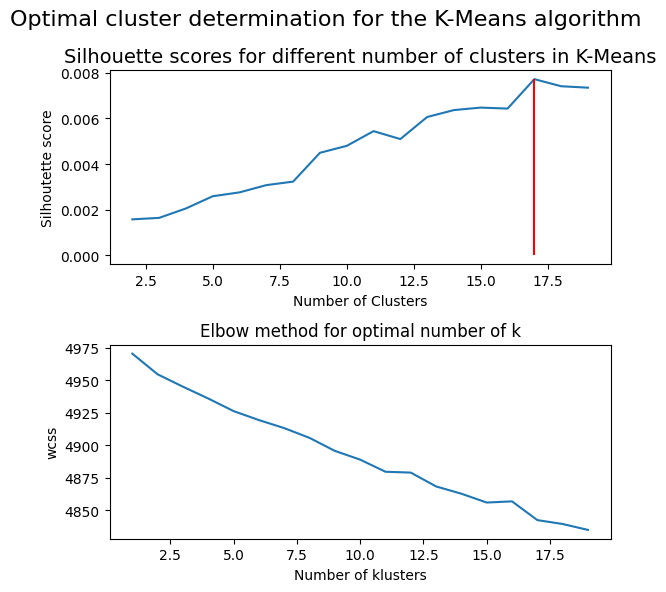

In [12]:
# Visualization of the Silhouette and wcss elbow method
fig, axs = plt.subplots(2,1, figsize =FIGSIZE_1)
plt.suptitle("Optimal cluster determination for the K-Means algorithm", fontsize = 16)
axs[0].plot(range(2,20), silhouetter_scores)
axs[0].vlines(optimal_clusters_kmeans, ymin = 0, ymax= max(silhouetter_scores), color = "red")
axs[0].set_xlabel("Number of Clusters")
axs[0].set_ylabel("Silhoutette score")
axs[0].set_title("Silhouette scores for different number of clusters in K-Means", fontdict={"fontsize": 14})

axs[1].plot(range(1,20), wcss)
axs[1].set_xlabel("Number of klusters")
axs[1].set_ylabel("wcss")
axs[1].set_title("Elbow method for optimal number of k")

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "KMeans cluster number evaluation.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [44]:
# Defining the general number of words per cluster that should be
# outputted through the whole file
N_OUT = 8

# Creating output function for the words in clusters to see what kind of words are
# being put into which cluster and see if there is according to human sense a
# connection between the words.
def get_top_keywords(n_terms: int, clusters: list, vectorizer: TfidfVectorizer):
    df = pd.DataFrame(vect_text.todense()).groupby(clusters).mean()
    terms = vectorizer.get_feature_names_out()
    for i, r in df.iterrows():
        print(f"\nCluster {i}")
        print(", ".join([terms[t] for t in np.argsort(r)[-n_terms:]]))

# -----Model training for the silhouette results-----
# First try with 11 Clusters

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=Warning) 

kmean = KMeans(n_clusters= 11, random_state= 123)
kmean.fit(vect_text.toarray())

clusters = kmean.labels_

df_text_clean['cluster_kmeans_11'] = clusters
df_text_clean['cluster_kmeans_11'] = df_text_clean['cluster_kmeans_11']

get_top_keywords(N_OUT, clusters, vectorizer)

# Second try with optimal number of clusters 17
kmean = KMeans(n_clusters= optimal_clusters_kmeans, random_state= 123)
kmean.fit(vect_text.toarray())

clusters = kmean.labels_

df_text_clean['cluster_kmeans_17'] = clusters
df_text_clean['cluster_kmeans_17'] = df_text_clean['cluster_kmeans_17']
    
get_top_keywords(N_OUT, clusters, vectorizer)

# -----Model training for the wcss results-----
# First try with 5 clusters
kmean = KMeans(n_clusters= 2, random_state= 123)
kmean.fit(vect_text.toarray())

clusters = kmean.labels_

df_text_clean['cluster_kmeans_2'] = clusters
df_text_clean['cluster_kmeans_2'] = df_text_clean['cluster_kmeans_2']

get_top_keywords(N_OUT, clusters, vectorizer)

# Second try with 13 clusters
kmean = KMeans(n_clusters= 15, random_state= 123)
kmean.fit(vect_text.toarray())

clusters = kmean.labels_

df_text_clean['cluster_kmeans_15'] = clusters
df_text_clean['cluster_kmeans_15'] = df_text_clean['cluster_kmeans_15']

get_top_keywords(N_OUT, clusters, vectorizer)



Cluster 0
titl, leader, england, break, win, cup, record, world

Cluster 1
japan, blow, report, free, climat, industri, trade, chang

Cluster 2
australian, crash, kill, court, plan, report, win, australia

Cluster 3
afghanistan, tikrit, blaze, iraq, famili, return, troop, home

Cluster 4
loom, mp, sydney, door, hospit, australian, open, say

Cluster 5
offic, hunt, car, man, probe, shoot, investig, polic

Cluster 6
car, jail, drug, court, face, murder, charg, man

Cluster 7
govt, voter, new, urg, land, mayor, plan, council

Cluster 8
leak, dant, smith, chris, brett, david, michael, interview

Cluster 9
coal, budget, fund, train, cut, farmer, nsw, govt

Cluster 10
open, coronavirus, hospit, unveil, year, wa, zealand, new

Cluster 0
world, sydney, kill, report, court, man, interview, say

Cluster 1
new, india, missil, day, korea, second, nuclear, test

Cluster 2
murder, arrest, offic, man, probe, shoot, investig, polic

Cluster 3
guidelin, wa, deal, govt, hospit, year, zealand, new

Clus

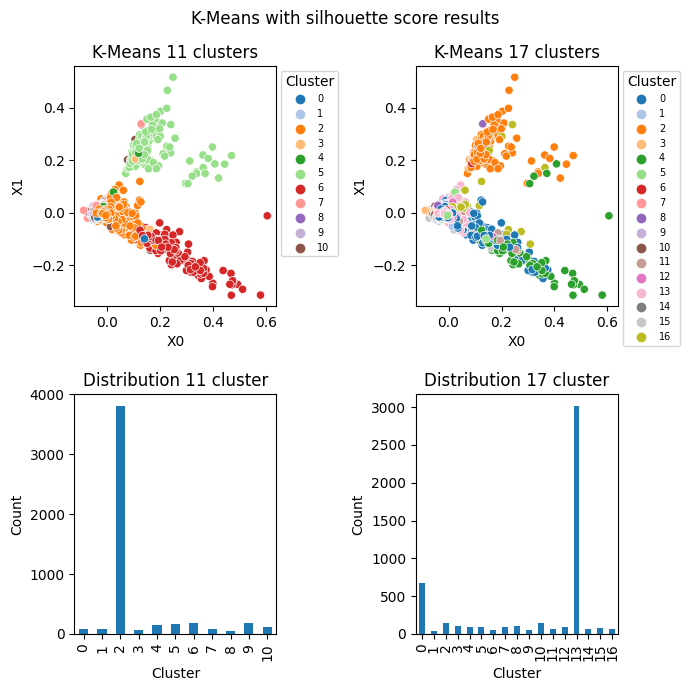

In [68]:
# Visualizing the kmeans clusters for the silhouette results
import seaborn as sns

fig, axs = plt.subplots(2,2, figsize=FIGSIZE_2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.45,hspace=0.45)
plt.suptitle("K-Means with silhouette score results")

# Plotting clusters
axs[0,0].set_title("K-Means 11 clusters", fontdict={"fontsize": 12})
axs[0,0].set_xlabel("X0")
axs[0,0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,0], x = "x0", y = "x1", palette= "tab20", hue= "cluster_kmeans_11", hue_order=[i for i in range(0, 11)])
axs[0,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1), fontsize = 7)

axs[0,1].set_title("K-Means 17 clusters", fontdict={"fontsize": 12})
axs[0,1].set_xlabel("X0")
axs[0,1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,1], x = "x0", y = "x1", palette= "tab20", hue= "cluster_kmeans_17", hue_order=[i for i in range(0, 17)])
axs[0,1].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

# Plotting distributions
df_text_clean['cluster_kmeans_11'].value_counts().sort_index().plot(kind='bar', ax = axs[1,0])
axs[1,0].set_title("Distribution 11 cluster")
axs[1,0].set_xlabel("Cluster")
axs[1,0].set_ylabel("Count")

df_text_clean['cluster_kmeans_17'].value_counts().sort_index().plot(kind='bar', ax = axs[1,1])
axs[1,1].set_title(f"Distribution {optimal_clusters_kmeans} cluster")
axs[1,1].set_xlabel("Cluster")
axs[1,1].set_ylabel("Count")

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Silhouette plot clusters KMeans.png"), bbox_inches = "tight", dpi = 400)
plt.show()

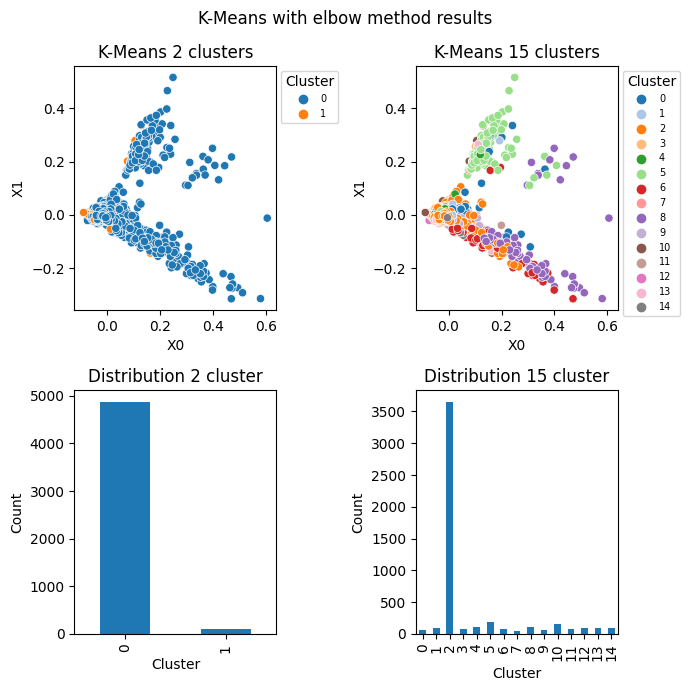

In [46]:
# Visualization of the K-Means results for the wcss results
fig, axs = plt.subplots(2,2, figsize=FIGSIZE_2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.45,hspace=0.45)
plt.suptitle("K-Means with elbow method results")

# Plotting clusters
axs[0,0].set_title("K-Means 2 clusters", fontdict={"fontsize": 12})
axs[0,0].set_xlabel("X0")
axs[0,0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,0], x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_2", hue_order=[i for i in range(0, 2)])
axs[0,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

axs[0,1].set_title("K-Means 15 clusters", fontdict={"fontsize": 12})
axs[0,1].set_xlabel("X0")
axs[0,1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,1], x = "x0", y = "x1", palette= "tab20", hue= "cluster_kmeans_15", hue_order=[i for i in range(0, 15)])
axs[0,1].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

# Plotting distributions
df_text_clean['cluster_kmeans_2'].value_counts().sort_index().plot(kind='bar', ax = axs[1,0])
axs[1,0].set_title("Distribution 2 cluster")
axs[1,0].set_xlabel("Cluster")
axs[1,0].set_ylabel("Count")

df_text_clean['cluster_kmeans_15'].value_counts().sort_index().plot(kind='bar', ax = axs[1,1])
axs[1,1].set_title(f"Distribution 15 cluster")
axs[1,1].set_xlabel("Cluster")
axs[1,1].set_ylabel("Count")

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Elbow method plot clusters KMeans.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [31]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# Default settings
silhouetter_score_default = []
wcss_score = []

# Function to calculate WCSS for a given clustering
def calculate_wcss(X, labels):
    wcss = 0
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        cluster_center = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - cluster_center) ** 2)
    return wcss

# Loop over the range of clusters
for k in range(2, 20):
    agglo = AgglomerativeClustering(n_clusters=k)
    temp_labels = agglo.fit_predict(vect_text.toarray())
    
    # Silhouette score
    score = silhouette_score(vect_text, temp_labels)
    silhouetter_score_default.append(score)
    
    # WCSS score
    wcss = calculate_wcss(vect_text.toarray(), temp_labels)
    wcss_score.append(wcss)

# Determine optimal number of clusters based on silhouette score
optimal_clusters_default = silhouetter_score_default.index(max(silhouetter_score_default)) + 2
print(f"Optimal number of clusters from silhouette score results default settings: {optimal_clusters_default}")



Optimal number of clusters from silhouette score results default settings: 2


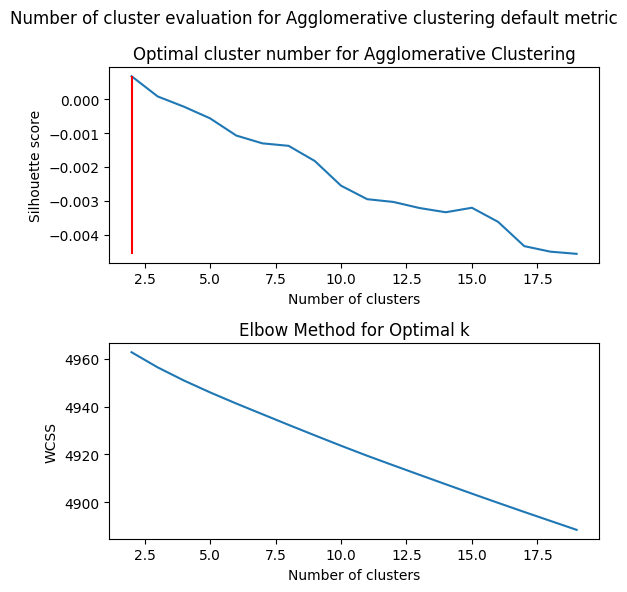

In [62]:
fig, axs = plt.subplots(2,1, figsize=FIGSIZE_1)
plt.suptitle("Number of cluster evaluation for Agglomerative clustering default metric", fontsize = 12)

axs[0].plot(range(2,20), silhouetter_score_default)
axs[0].vlines(optimal_clusters_default, ymin = min(silhouetter_score_default), ymax = max(silhouetter_score_default), color = "red")
axs[0].set_title("Optimal cluster number for Agglomerative Clustering")
axs[0].set_ylabel("Silhouette score")
axs[0].set_xlabel("Number of clusters")

axs[1].plot(range(2, 20), wcss_score)
axs[1].set_title('Elbow Method for Optimal k')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('WCSS')


plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Silhouette scores Agglo.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [33]:
silhouetter_score_cosine = []
wcss_score_cosine = []

# Loop over the range of clusters
for k in range(2, 20):
    agglo = AgglomerativeClustering(n_clusters=k, metric="cosine", linkage="average")
    temp_labels = agglo.fit_predict(vect_text.toarray())
    
    # Silhouette score
    score = silhouette_score(vect_text, temp_labels)
    silhouetter_score_cosine.append(score)
    
    # WCSS score
    wcss = calculate_wcss(vect_text.toarray(), temp_labels)
    wcss_score_cosine.append(wcss)

# Determine optimal number of clusters based on silhouette score
optimal_clusters_cosine = silhouetter_score_cosine.index(max(silhouetter_score_cosine)) + 2
print(f"Optimal number of clusters from silhouette score results default settings: {optimal_clusters_cosine}")


Optimal number of clusters from silhouette score results default settings: 2


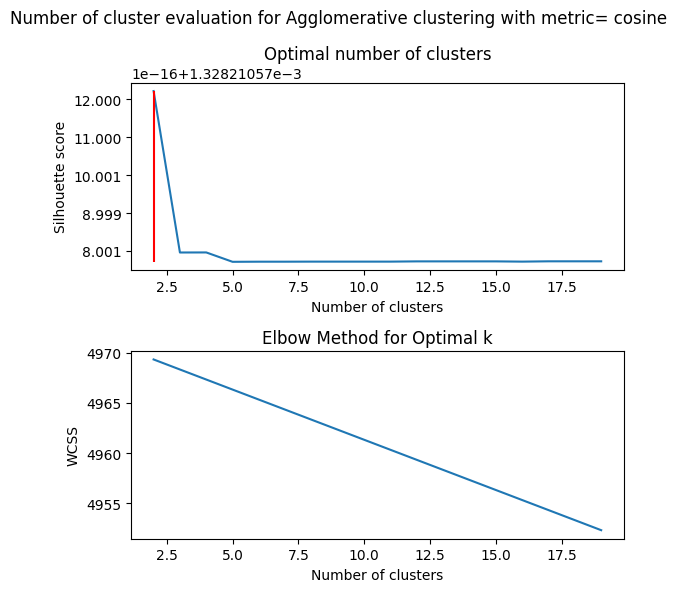

In [34]:
fig, axs = plt.subplots(2,1, figsize=FIGSIZE_1)
plt.suptitle("Number of cluster evaluation for Agglomerative clustering with metric= cosine", fontsize = 12)

axs[0].plot(range(2,20), silhouetter_score_cosine)
axs[0].vlines(optimal_clusters_cosine, ymin = min(silhouetter_score_cosine), ymax = max(silhouetter_score_cosine), color = "red")
axs[0].set_title("Optimal number of clusters")
axs[0].set_ylabel("Silhouette score")
axs[0].set_xlabel("Number of clusters")

axs[1].plot(range(2, 20), wcss_score_cosine)
axs[1].set_title('Elbow Method for Optimal k')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('WCSS')


plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Silhouette scores Agglo cosine.png"), bbox_inches = "tight", dpi = 400)
plt.show()

In [35]:

agglo_default = AgglomerativeClustering(n_clusters= optimal_clusters_default)
agglo_default.fit_predict(vect_text.toarray())
labels_default = agglo_default.labels_

print("\n\n-----------Results for default-----------")
for i, headline in enumerate(raw_text_list[:10]):
    print(f"Headline: {headline} | Cluster: {labels_default[i]}")



-----------Results for default-----------
Headline: qld's first cyclone predicted to form in coral sea this week | Cluster: 1
Headline: wa government backs down over parking fees | Cluster: 1
Headline: interview bill leak | Cluster: 1
Headline: spanish judge issues warrants for us soldiers | Cluster: 1
Headline: rising swan ready for all comers | Cluster: 1
Headline: chinese govt apologises for hostage drama | Cluster: 1
Headline: marton loses taekwondo semi finals | Cluster: 1
Headline: tigers lose kendall for season | Cluster: 1
Headline: world cup win would top the lot marsh | Cluster: 1
Headline: mick fanning's brother peter dies on eve of world title showdown | Cluster: 1


In [36]:
# Visualization of the first try out with Aggolomerative Clustering and default values

from sklearn.cluster import AgglomerativeClustering

# First try with 2 Clusters

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=Warning) 
 
agglo = AgglomerativeClustering(n_clusters= optimal_clusters_default)
agglo.fit(vect_text.toarray())

clusters = agglo.labels_

df_text_clean['cluster_agglo_2'] = clusters
df_text_clean['cluster_agglo_2'] = df_text_clean['cluster_agglo_2'].astype("category")
       
        
get_top_keywords(N_OUT, clusters, vectorizer)


agglo = AgglomerativeClustering(n_clusters= 3)
agglo.fit(vect_text.toarray())

clusters = agglo.labels_

df_text_clean['cluster_agglo_3'] = clusters
df_text_clean['cluster_agglo_3'] = df_text_clean['cluster_agglo_3'].astype("category")
       
        
get_top_keywords(N_OUT, clusters, vectorizer)


Cluster 0
car, kill, murder, court, crash, charg, man, polic

Cluster 1
report, win, plan, govt, council, australia, say, new

Cluster 0
arrest, investig, drug, murder, court, man, charg, polic

Cluster 1
report, win, plan, govt, council, australia, say, new

Cluster 2
collis, polic, injur, fatal, highway, kill, car, crash


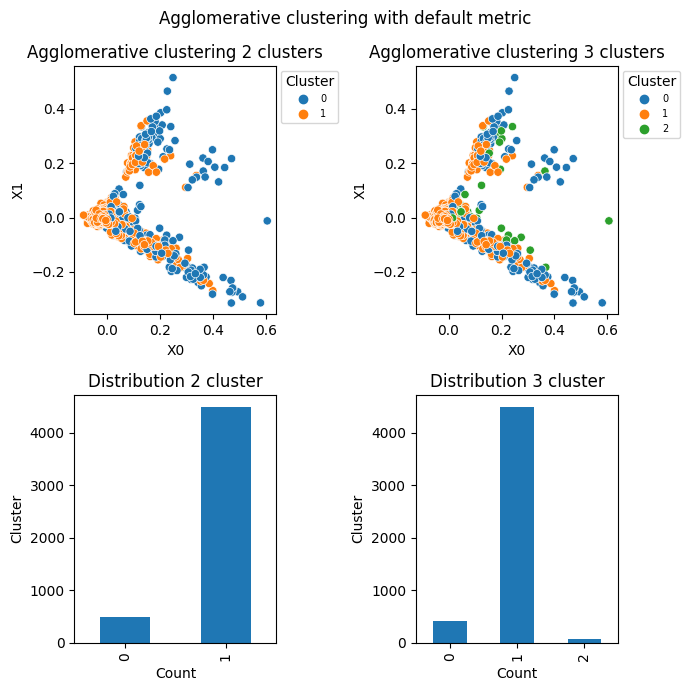

In [69]:
fig, axs = plt.subplots(2,2, figsize=FIGSIZE_2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.45,hspace=0.45)
plt.suptitle("Agglomerative clustering with default metric")

axs[0,0].set_title(f"Agglomerative clustering {optimal_clusters_default} clusters", fontdict={"fontsize": 12})
axs[0,0].set_xlabel("X0")
axs[0,0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,0], x = "x0", y = "x1", palette= "tab10", hue= "cluster_agglo_2", hue_order=[i for i in range(0, optimal_clusters_default)])
axs[0,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

axs[0,1].set_title("Agglomerative clustering 3 clusters", fontdict={"fontsize": 12})
axs[0,1].set_xlabel("X0")
axs[0,1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,1], x = "x0", y= "x1", palette = "tab10", hue= "cluster_agglo_3", hue_order=[i for i in range(0, 3)])
axs[0,1].legend(title= "Cluster", loc= "upper left", bbox_to_anchor= (1,1), fontsize= 7)

axs[1,0].set_title("Distribution 2 cluster", fontdict={"fontsize": 12})
axs[1,0].set_xlabel("Count")
axs[1,0].set_ylabel("Cluster")
df_text_clean['cluster_agglo_2'].value_counts().sort_index().plot(kind='bar', ax= axs[1,0])

axs[1,1].set_title("Distribution 3 cluster", fontdict={"fontsize": 12})
axs[1,1].set_xlabel("Count")
axs[1,1].set_ylabel("Cluster")
df_text_clean['cluster_agglo_3'].value_counts().sort_index().plot(kind='bar', ax= axs[1,1])

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Agglo default cluster.png"), bbox_inches = "tight")
plt.show()

In [40]:
from sklearn.cluster import AgglomerativeClustering

# First try with 2 Clusters

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=Warning) 
 
agglo = AgglomerativeClustering(n_clusters= optimal_clusters_cosine, linkage= "average", metric= "cosine")
agglo.fit(vect_text.toarray())

clusters = agglo.labels_

df_text_clean['cluster_agglo_cosine_2'] = clusters
df_text_clean['cluster_agglo_cosine_2'] = df_text_clean['cluster_agglo_cosine_2'].astype("category")
       
        
get_top_keywords(N_OUT, clusters, vectorizer)


agglo = AgglomerativeClustering(n_clusters= 3, linkage= "average", metric= "cosine")
agglo.fit(vect_text.toarray())

clusters = agglo.labels_

df_text_clean['cluster_agglo_cosine_3'] = clusters
df_text_clean['cluster_agglo_cosine_3'] = df_text_clean['cluster_agglo_cosine_3'].astype("category")
       
        
get_top_keywords(N_OUT, clusters, vectorizer)


Cluster 0
randwick, vacc, rinehardt, torqu, skydiv, downhil, couch, bushwalk

Cluster 1
plan, council, australia, charg, say, new, man, polic

Cluster 0
shiraz, carolin, skydiv, downhil, torqu, couch, rinehardt, bushwalk

Cluster 1
plan, council, australia, charg, say, new, man, polic

Cluster 2
fitzi, fitzgibbon, fitzgerald, fitch, flag, zygier, gallagh, birth


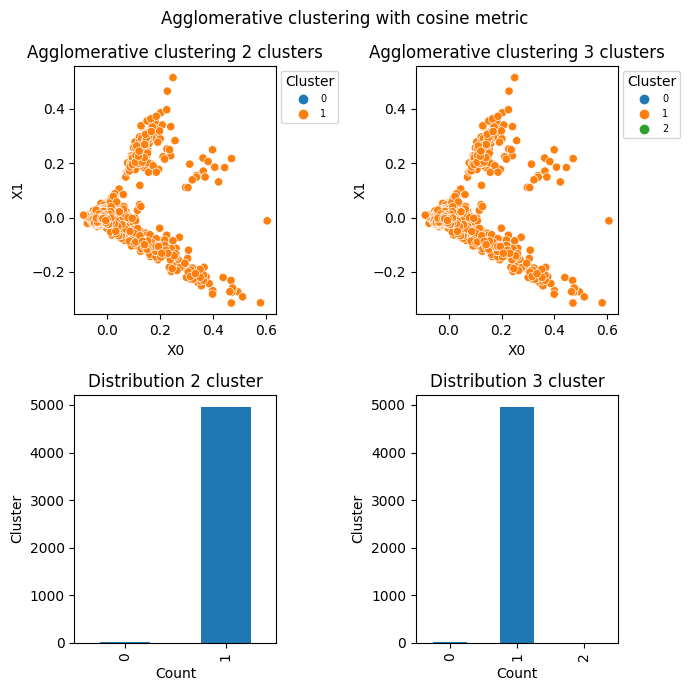

In [70]:
fig, axs = plt.subplots(2,2, figsize=FIGSIZE_2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.45,hspace=0.45)
plt.suptitle("Agglomerative clustering with cosine metric")

axs[0,0].set_title(f"Agglomerative clustering {optimal_clusters_cosine} clusters", fontdict={"fontsize": 12})
axs[0,0].set_xlabel("X0")
axs[0,0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,0], x = "x0", y = "x1", palette= "tab10", hue= "cluster_agglo_cosine_2", hue_order=[i for i in range(0, optimal_clusters_cosine)])
axs[0,0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor = (1, 1),  fontsize = 7)

axs[0,1].set_title("Agglomerative clustering 3 clusters", fontdict={"fontsize": 12})
axs[0,1].set_xlabel("X0")
axs[0,1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean, ax= axs[0,1], x = "x0", y= "x1", palette = "tab10", hue= "cluster_agglo_cosine_3", hue_order=[i for i in range(0, 3)])
axs[0,1].legend(title= "Cluster", loc= "upper left", bbox_to_anchor= (1,1), fontsize= 7)

axs[1,0].set_title("Distribution 2 cluster", fontdict={"fontsize": 12})
axs[1,0].set_xlabel("Count")
axs[1,0].set_ylabel("Cluster")
df_text_clean['cluster_agglo_cosine_2'].value_counts().sort_index().plot(kind='bar', ax= axs[1,0])

axs[1,1].set_title("Distribution 3 cluster", fontdict={"fontsize": 12})
axs[1,1].set_xlabel("Count")
axs[1,1].set_ylabel("Cluster")
df_text_clean['cluster_agglo_cosine_3'].value_counts().sort_index().plot(kind='bar', ax= axs[1,1])

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Agglo cosine cluster.png"), bbox_inches = "tight")
plt.show()

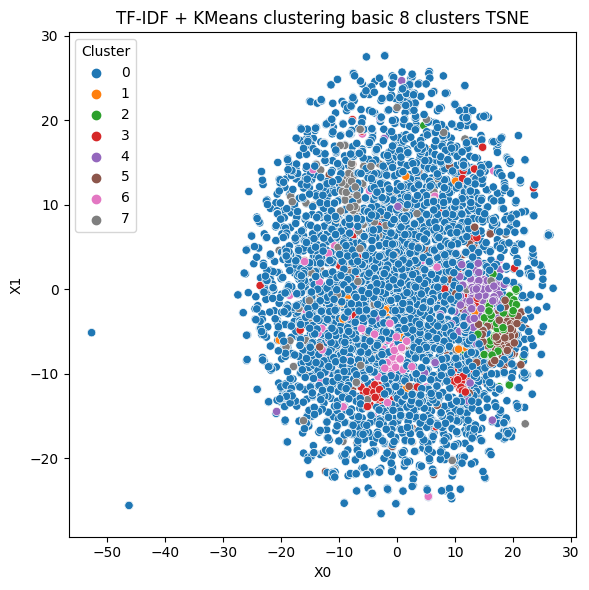

In [45]:
# Basic Kmeans
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore', category=FutureWarning) 

kmean = KMeans(max_iter= 500, random_state= 123)
kmean.fit(vect_text)

clusters = kmean.labels_

df_text_clean2['cluster_kmeans_basic'] = clusters

"""
Only here if further analysis is still needed

import seaborn as sns

plt.figure(figsize=FIGSIZE_1)
plt.title("TF-IDF + KMeans clustering basic 8 clusters TSNE")
plt.xlabel("X0")
plt.ylabel("X1")
sns.scatterplot(data= df_text_clean2, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
plt.legend(title = "Cluster")
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "K-Means 8 clusters TSNE.png"), bbox_inches = "tight")
plt.show()
"""

In [ ]:
# Tryout with another dimensionality reduction


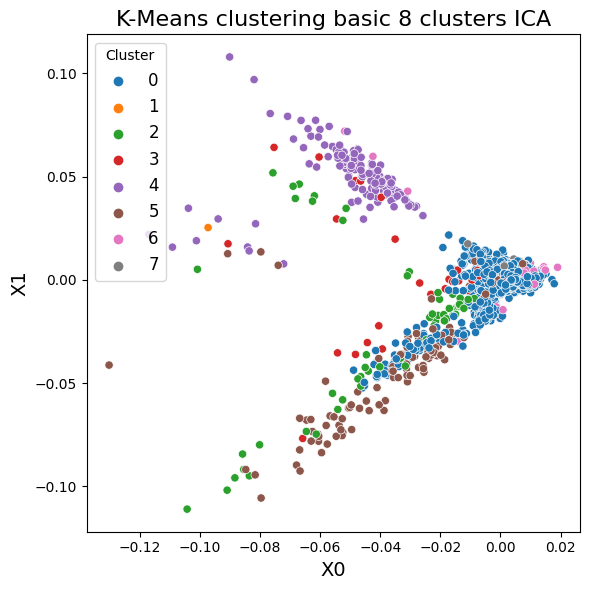

In [46]:
# Basic Kmeans
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore', category=FutureWarning) 

kmean = KMeans(max_iter= 500, random_state= 123)
kmean.fit(vect_text)

clusters = kmean.labels_

df_text_clean3['cluster_kmeans_basic'] = clusters

"""
Only here if further analysis is still needed

import seaborn as sns

plt.figure(figsize=FIGSIZE_1)
plt.title("K-Means clustering basic 8 clusters ICA", fontdict={"fontsize": 16})
plt.xlabel("X0", fontdict={"fontsize": 14})
plt.ylabel("X1", fontdict={"fontsize": 14})
sns.scatterplot(data= df_text_clean3, x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
plt.legend(title = "Cluster", fontsize = 12)
plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "KMeans 8 clusters ICA.png"), bbox_inches = "tight")
plt.show()

"""

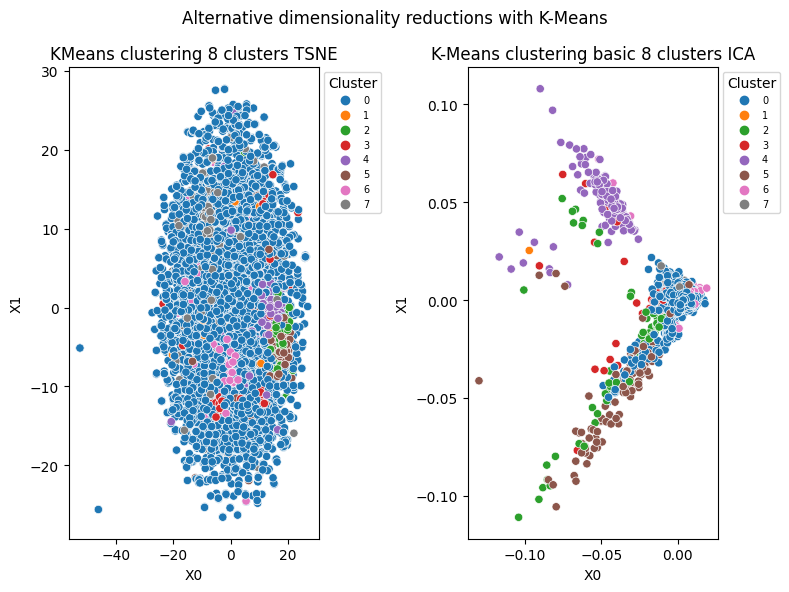

In [60]:
fig, axs = plt.subplots(1,2, figsize= (8,6))
plt.suptitle("Alternative dimensionality reductions with K-Means")

axs[0].set_title("KMeans clustering 8 clusters TSNE", fontdict={"fontsize": 12})
axs[0].set_xlabel("X0")
axs[0].set_ylabel("X1")
sns.scatterplot(data= df_text_clean2, ax= axs[0], x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
axs[0].legend(title = "Cluster", loc= "upper left", bbox_to_anchor= (1,1), fontsize= 7)

axs[1].set_title("K-Means clustering basic 8 clusters ICA", fontdict={"fontsize": 12})
axs[1].set_xlabel("X0")
axs[1].set_ylabel("X1")
sns.scatterplot(data= df_text_clean3, ax= axs[1], x = "x0", y = "x1", palette= "tab10", hue= "cluster_kmeans_basic", hue_order=[i for i in range(0, 8)])
axs[1].legend(title = "Cluster", loc= "upper left", bbox_to_anchor= (1,1), fontsize= 7)

plt.tight_layout()
plt.savefig(os.path.join(picture_savepath, "Alternative dimensionality reduction.png"), bbox_inches = "tight")
plt.show()